**Importing Libraries**


In [23]:

import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer




Mounting Drive

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loading Files**


In [25]:
import pandas as pd

express_files = '/content/drive/MyDrive/ML PROJECT/express_articles.csv'
express_df = pd.read_csv(express_files)

geo_files = '/content/drive/MyDrive/ML PROJECT/geo_articles.csv'
geo_df = pd.read_csv(geo_files)

jang_files = '/content/drive/MyDrive/ML PROJECT/jang_articles.csv'
jang_df = pd.read_csv(jang_files)

urdu_articles = '/content/drive/MyDrive/ML PROJECT/urdu_articles (1).csv'
urdu_df = pd.read_csv(urdu_articles)




**Cleaning the Data**

In [26]:
def clean_data(df):
    # Drop rows where 'content' or 'title' are missing
    df = df.dropna(subset=["title", "content"]).copy()

    # Fill missing values in non-essential columns
    df["link"] = df["link"].fillna("No Link")
    df["id"] = df["id"].fillna(-1)
    df["content"] = df["content"].fillna("")

    # Remove duplicate articles
    df = df.drop_duplicates(subset=["title", "content"]).copy()

    # Outlier handling - filter based on content length
    df = df[df["content"].apply(len) > 50].copy()

    # Reset the index
    df = df.reset_index(drop=True)

    return df



# Apply the cleaning function
cleaned_df = clean_data(urdu_df)

# Check for duplicates
duplicates_count = cleaned_df.duplicated(subset=["title", "content"]).sum()
print("Number of duplicates:", duplicates_count)

# Check minimum content length
min_length = cleaned_df["content"].apply(len).min()
print("Minimum content length:", min_length)

# Additional checks
max_length = cleaned_df["content"].apply(len).max()
unique_titles = cleaned_df["title"].nunique()
print("Maximum content length:", max_length)
print("Number of unique titles:", unique_titles)
print("\n")

# Preview cleaned data
print(cleaned_df.head())

Number of duplicates: 0
Minimum content length: 92
Maximum content length: 7596
Number of unique titles: 1133


   id                                              title  \
0   0  ’’میرے پاس وقت نہیں...‘‘ ارجن سے علیحدگی کے بع...   
1   1  اداکارہ نرگس نے ساتھی فنکارہ کے خلاف ایف آئی ...   
2   2  اکشے کمار کی نئی کامیڈی فلم ’ہاؤس فل 5‘ کی شوٹ...   
3   3  عامر خان کے مشورے پر 'لاہور 1947' میں جذباتی م...   
4   4  راشمیکا مندانا کا فلم "پشپا 2" کے سیٹ کو جذبات...   

                                                link  \
0  https://www.express.pk/story/2735281/malaika-a...   
1  https://www.express.pk/story/2735225/adakarah-...   
2  https://www.express.pk/story/2735209/akshaykum...   
3  https://www.express.pk/story/2735208/amirkhan-...   
4  https://www.express.pk/story/2735207/rashmika-...   

                                             content     gold_label  
0  بھارتی اداکارہ ملائیکہ اروڑا نے ارجن کپور کے س...  entertainment  
1  اسٹیج اداکارہ نرگس نے ساتھی فنکارہ کے خلاف ایف.

**Tokenization and using n-gram feature extraction with bag of words**

In [27]:
# Installing urduhack to use for tokenization
#%pip install urduhack

#%pip install tensorflow

In [28]:
def tokenize_text(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = re.findall(r"\w+", text)
    return tokens

def generate_ngrams(tokens, n):
    ngrams = []
    for i in range(len(tokens) - n + 1):
        ngram = tuple(tokens[i:i + n])
        ngrams.append(ngram)
    return ngrams

def create_ngram_bow(text_series, n=2):
    ngram_counts = Counter()  # To count n-grams

    for text in text_series:
        tokens = tokenize_text(text)  # Tokenize the text
        ngrams = generate_ngrams(tokens, n)  # Generate n-grams
        ngram_counts.update(ngrams)  # Count n-grams

    # Create the feature names from the n-grams
    feature_names = [' '.join(ngram) for ngram in ngram_counts.keys()]

    # Create the feature matrix
    feature_matrix = np.zeros((len(text_series), len(feature_names)), dtype=int)

    # Fill in the feature matrix
    for doc_index, text in enumerate(text_series):
        tokens = tokenize_text(text)
        ngrams = generate_ngrams(tokens, n)
        ngram_counter = Counter(ngrams)

        for ngram, count in ngram_counter.items():
            if ngram in ngram_counts:
                feature_matrix[doc_index, feature_names.index(' '.join(ngram))] = count

    return feature_matrix, feature_names


creating fearure matrix for both title and content

In [30]:
X_title, title_features = create_ngram_bow(cleaned_df['title'], n=2)  # Bigrams
X_content, content_features = create_ngram_bow(cleaned_df['content'], n=2)

# Combining the two feature matrices
X_combined = np.hstack((X_title, X_content))

Encoding y labels

In [31]:

labels = cleaned_df["gold_label"].unique()  # Get unique labels
label_to_id = {category: idx for idx, category in enumerate(labels)}

# Encode labels
y = cleaned_df["gold_label"].map(label_to_id).values


Peforming Train/Test split

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

Multinomial Bayes Model implementation

In [47]:

class MultinomialNaiveBayes:
    def __init__(self):
        self.class_priors = {}  # log probabilities of each label
        self.word_likelihoods = {}  # log probabilities for each word for each label
        self.vocab_size = 0  # number of unique words across dataset



    def fit(self, X, y , alpha=1):

        num_samples = len(y)

        # Get unique labels and their counts
        labels, label_counts = np.unique(y, return_counts=True)

        # Calculate class priors: P(c)
        for cls, count in zip(labels, label_counts):
            self.class_priors[cls] = np.log(count / num_samples)  # Take log of probabilities

        self.word_likelihoods = {cls: np.zeros(X.shape[1]) for cls in labels}
        total_words_per_class = {cls: 0 for cls in labels}  # To keep total word counts for each class/label

        # Count occurrences of each word per class/label
        for i in range(num_samples):
            cls = y[i]
            total_words_per_class[cls] += np.sum(X[i])  # Total words in this class
            self.word_likelihoods[cls] += X[i]  # Sum the word counts for the class

        # Apply Laplace smoothing
        for cls in labels:
          # Total count of words in class c
          total_count = total_words_per_class[cls]
          smoothed_word_counts = self.word_likelihoods[cls] + alpha  # Add 'alpha' for each word in vocabulary to avoid zero probabilities

          # Apply Lidstone smoothing formula
          self.word_likelihoods[cls] = smoothed_word_counts / (total_count + alpha * self.vocab_size)

        # Take Log of word likelihoods
        for cls in labels:
            self.word_likelihoods[cls] = np.log(self.word_likelihoods[cls])

        self.vocab_size = X.shape[1]  # Number of unique words

    def predict(self, X):
        predictions = []
        for i in range(X.shape[0]):
            log_probs = {}
            for cls in self.class_priors.keys():
                log_probs[cls] = self.class_priors[cls] + np.sum(X[i] * self.word_likelihoods[cls]) # Calculate log probability for each class

            predictions.append(max(log_probs, key=log_probs.get))   # Get the class with the highest log probability -> gold_label

        return np.array(predictions)





Training model and applying it to test data

In [48]:

mnb_model = MultinomialNaiveBayes()
mnb_model.fit(X_train, y_train,0.01) # alpha set to 0.01 -> best alpha chosen after hyperparameter tuning
predictions = mnb_model.predict(X_test)





Metrics for Test Data

In [49]:
# metrics TEST
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions , average='weighted')
f1 = f1_score(y_test, predictions , average='weighted')

print(" \nMETRICS FOR TEST SET :")
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

 
METRICS FOR TEST SET :
Accuracy: 95.59%
Precision: 0.96
Recall: 0.96
F1 Score: 0.96


Plotting Confusion Matrix

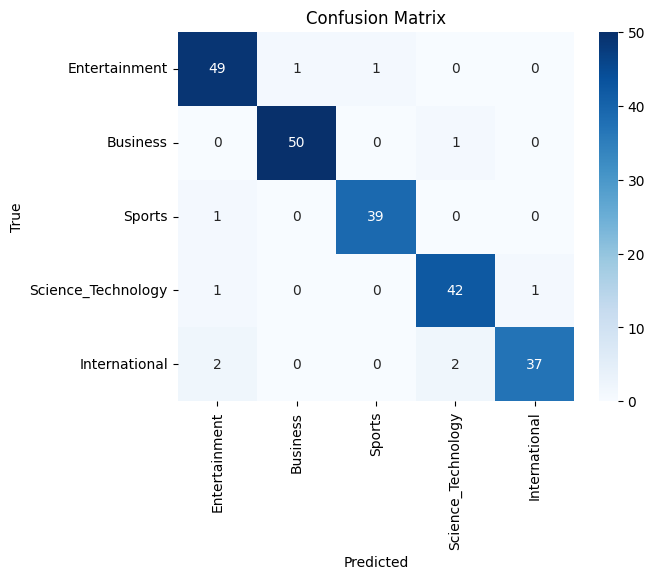

In [50]:
import seaborn as sns

class_names = ['Entertainment' , 'Business' , 'Sports' , 'Science_Technology' , 'International']
conf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()